<a href="https://colab.research.google.com/github/bttisrael/item-predictions/blob/main/item_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# ---PACKAGE ---
!pip install gurobipy db-dtypes pandas-gbq google-cloud-bigquery scikit-learn inflection

# --- LIBRARY ---
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Google Cloud
from google.colab import auth
from google.cloud import bigquery

# Configurações de Visualização
pd.set_option('display.max_columns', None)
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (15, 7)

In [11]:
# --- 1.1 AUTENTICATION ---
auth.authenticate_user()
project_id = 'otimizador-cargas' # Seu ID de projeto
client = bigquery.Client(project=project_id)

# --- 1.2 QUERY EXTRACTION AND AGREGATION ---
query = """
SELECT
    dt_venda as date,
    CAST(loja AS STRING) as store_id,
    CAST(cod_material AS STRING) as item_id,

    -- Target
    SUM(qt_venda_bruto) as sales,

    -- Features Numéricas
    AVG(vlr_venda_praticado) as price,
    AVG(vlr_tabelado) as list_price,

    -- Feature Engineering (Desconto)
    AVG( SAFE_DIVIDE((vlr_tabelado - vlr_venda_praticado), NULLIF(vlr_tabelado,0)) ) as discount_pct,

    -- Sazonalidade
    EXTRACT(DAYOFWEEK FROM dt_venda) as weekday,
    EXTRACT(MONTH FROM dt_venda) as month

FROM `otimizador-cargas.sales.sales_data`

WHERE
    qt_venda_bruto > 0
    AND dt_venda >= '2020-01-01'

GROUP BY 1, 2, 3, 8, 9
"""

df_raw = client.query(query).to_dataframe()
print(f" Data loaded: {df_raw.shape[0]} Rows | {df_raw.shape[1]} Columns.")

 Data loaded: 865638 Rows | 9 Columns.


In [12]:
df1 = df_raw.copy()

print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Cols: {df1.shape[1]}")

display(df1.head())

Number of Rows: 865638
Number of Cols: 9


,date,store_id,item_id,sales,price,list_price,discount_pct,weekday,month
0,2021-10-05,1,212400,3,134.079,237.83,0.436240,3,10
1,2025-05-25,1,212400,21,152.830,152.83,0.000000,1,5
2,2025-05-20,1,212400,15,152.830,152.83,0.000000,3,5
3,2022-11-16,1,212400,6,168.708,178.33,0.053956,4,11
4,2023-10-26,7,212400,3,163.999,215.73,0.239795,5,10


In [13]:
cols_old = df1.columns.tolist()

# Functions lambda to snake_case
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Rename columns
df1.columns = cols_new

print("Colunas atuais:", df1.columns.tolist())

Colunas atuais: ['date', 'store_id', 'item_id', 'sales', 'price', 'list_price', 'discount_pct', 'weekday', 'month']


 Nulls by Column ---
discount_pct    106
dtype: int64

 Finance impact ---
Rows with critical missing data: 106 (0.01%)
Sales affected: 471 unidades
Share by total: 0.0078%


<Axes: >

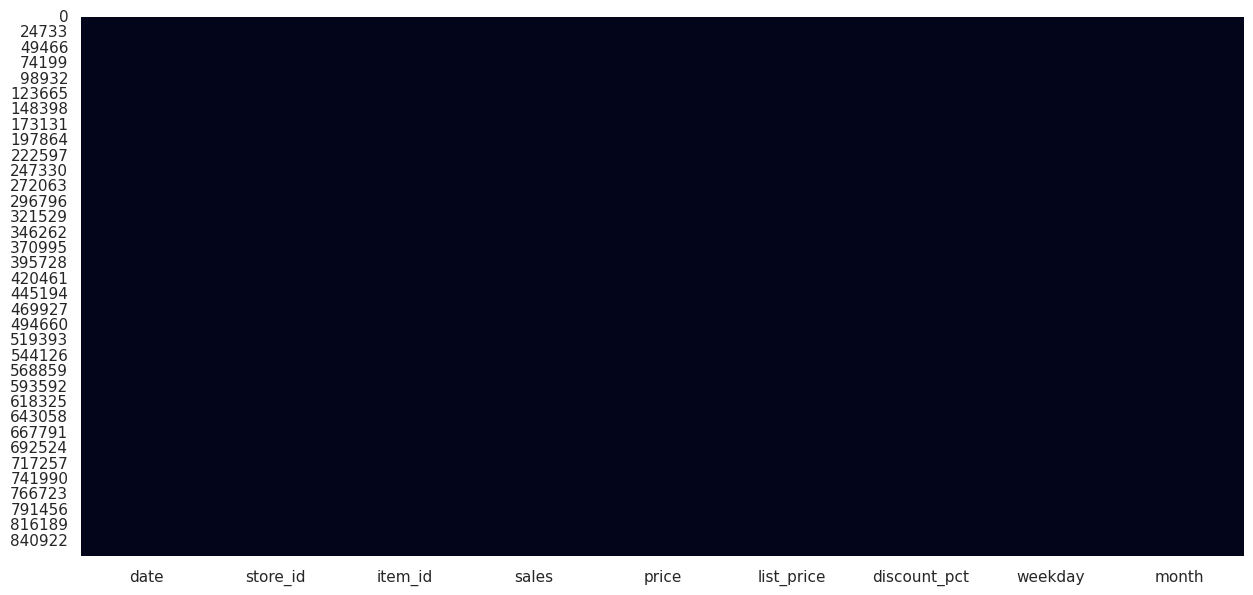

In [14]:
# 1.3 CHECK NA
na_counts = df1.isna().sum()
total_rows = len(df1)

print(" Nulls by Column ---")
print(na_counts[na_counts > 0])

# Impact Analysis (By removing nulls, we lost how much in sales?)
# Verifying rows where 'price' or 'list_price' are nulls
cols_critical = ['price', 'list_price', 'discount_pct']
mask_na = df1[cols_critical].isna().any(axis=1)

sales_lost = df1.loc[mask_na, 'sales'].sum()
total_sales = df1['sales'].sum()

print("\n Finance impact ---")
print(f"Rows with critical missing data: {mask_na.sum()} ({mask_na.sum()/total_rows:.2%})")
print(f"Sales affected: {sales_lost:,.0f} unidades")
print(f"Share by total: {(sales_lost/total_sales)*100:.4f}%")


sns.heatmap(df1.isnull(), cbar=False)

In [15]:
# Converting to datetime
df1['date'] = pd.to_datetime(df1['date'])

# ID to string
df1['store_id'] = df1['store_id'].astype(str)
df1['item_id'] = df1['item_id'].astype(str)

# Numbers to float (except sales which is int)
df1['price'] = df1['price'].astype(float)
df1['list_price'] = df1['list_price'].astype(float)
df1['discount_pct'] = df1['discount_pct'].astype(float)
df1['sales'] = df1['sales'].astype(int)

df1.dtypes

,0
date,datetime64[ns]
store_id,object
item_id,object
sales,int64
price,float64
list_price,float64
discount_pct,float64
weekday,Int64
month,Int64


⏳ Calculating statistics...
--- Descriptive Statistics (Numerical) ---


,min,max,range,mean,median,std,skew,kurtosis
sales,3.00000,1308.000000,1305.000000,6.980866,3.000,12.603336,14.036505,493.271837
price,-15.74200,10861.793000,10877.535000,97.179542,81.583,71.264131,22.649437,2548.034763
list_price,0.00000,17334.220000,17334.220000,104.911504,84.983,75.267603,31.255806,4893.563096
discount_pct,-949.03125,1.192957,950.224207,0.076515,0.000,1.029982,-904.008561,833032.998375
weekday,1.00000,7.000000,6.000000,4.431365,5.000,1.911343,-0.204525,-1.171109
month,1.00000,12.000000,11.000000,6.824204,7.000,3.637678,-0.112421,-1.278777



⏳ Generating plots (using 50k sample)...


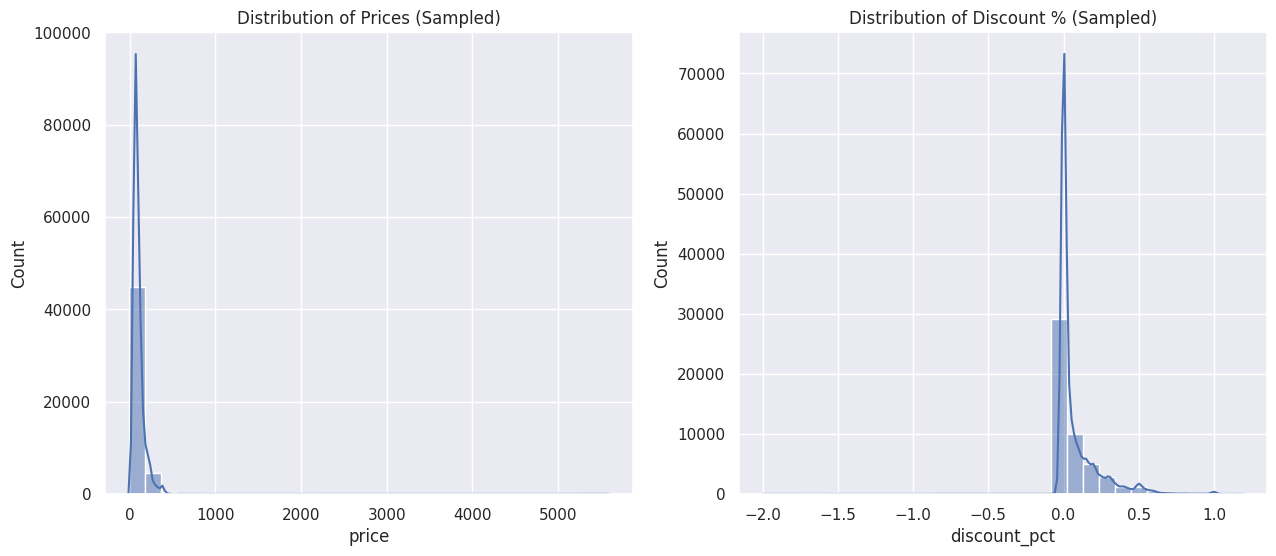


Total Unique Stores: 69
Total Unique Items: 2646


In [16]:
# ==============================================================================
# 1.4. DESCRIPTIVE STATISTICS
# ==============================================================================

# Separate Numerical and Categorical columns
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

# --- 1.4.1 Numerical Attributes (Fast Aggregation) ---
# Using .agg is faster than .apply because it uses optimized C-backend
print("⏳ Calculating statistics...")

# Calculate basic metrics in one go
metrics = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']).T

# Calculate Range (Vectorized operation is instant)
metrics['range'] = metrics['max'] - metrics['min']

# Reorder columns to match your preferred output
metrics = metrics[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

print("--- Descriptive Statistics (Numerical) ---")
display(metrics)

# --- 1.4.2 Visualization (Optimized with Sampling) ---
# Plotting millions of rows with KDE is slow. We use a sample for visualization.
# 50k rows are statistically sufficient to see the distribution shape.
print("\n⏳ Generating plots (using 50k sample)...")

sample_size = min(50000, len(df1))
df_sample = df1.sample(n=sample_size, random_state=42)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_sample['price'], kde=True, bins=30)
plt.title('Distribution of Prices (Sampled)')

plt.subplot(1, 2, 2)
sns.histplot(df_sample['discount_pct'], kde=True, bins=30)
plt.title('Distribution of Discount % (Sampled)')

plt.show()

# --- 1.4.3 Categorical Attributes ---
# nunique() is generally faster than len(unique())
print(f"\nTotal Unique Stores: {df1['store_id'].nunique()}")
print(f"Total Unique Items: {df1['item_id'].nunique()}")

In [17]:
# ==============================================================================
# 2.0. FEATURE ENGINEERING
# (Price) with Tendency
# ==============================================================================

fe_query = """
WITH daily_agg AS (
    SELECT
        dt_venda as date,
        CAST(loja AS STRING) as store_id,
        CAST(cod_material AS STRING) as item_id,

        -- Target
        SUM(qt_venda_bruto) as sales,

        -- Price Features
        AVG(vlr_venda_praticado) as price,
        AVG(vlr_tabelado) as list_price,

        -- Time Features
        EXTRACT(DAYOFWEEK FROM dt_venda) as weekday,
        EXTRACT(WEEK FROM dt_venda) as week_of_year,
        EXTRACT(MONTH FROM dt_venda) as month

    FROM `otimizador-cargas.sales.sales_data`
    WHERE
        qt_venda_bruto > 0
        AND vlr_venda_praticado > 0
        AND dt_venda >= '2020-01-01'
    GROUP BY 1, 2, 3, 7, 8, 9
)

SELECT
    *,


    -- Lag 7: How much has sold last week in this day?
    LAG(sales, 7) OVER (PARTITION BY store_id, item_id ORDER BY date) as sales_lag_7,

    -- Moving avarege 28 days
    AVG(sales) OVER (
        PARTITION BY store_id, item_id
        ORDER BY UNIX_DATE(date)
        RANGE BETWEEN 28 PRECEDING AND 1 PRECEDING
    ) as sales_ma_28d,


    -- Discount %: How agressive is the today offer?
    SAFE_DIVIDE((list_price - price), NULLIF(list_price,0)) as discount_pct,

    -- Price Ratio: The actual price is cheaper than the price in last 28 days?
    SAFE_DIVIDE(price, AVG(price) OVER (
        PARTITION BY store_id, item_id
        ORDER BY UNIX_DATE(date)
        RANGE BETWEEN 28 PRECEDING AND 1 PRECEDING
    )) as price_ratio

FROM daily_agg
ORDER BY store_id, item_id, date
"""

print("Getting the Features...")
df_final = client.query(fe_query).to_dataframe()

# Droping nulls generated by Lags
df_final = df_final.dropna(subset=['sales_lag_7', 'sales_ma_28d', 'price_ratio'])
df_final['date'] = pd.to_datetime(df_final['date'])

print(f"Final df rows: {len(df_final)}")
display(df_final.head())

Getting the Features...
Final df rows: 692712


,date,store_id,item_id,sales,price,list_price,weekday,week_of_year,month,sales_lag_7,sales_ma_28d,discount_pct,price_ratio
7,2024-02-29,1,10000000,126,57.651675,71.221500,5,8,2,126,164.142857,0.190530,0.950033
8,2024-03-01,1,10000000,147,60.469386,75.537955,6,8,3,165,159.375000,0.199483,1.002729
9,2024-03-02,1,10000000,234,63.149246,81.396000,7,8,3,309,158.000000,0.224173,1.046850
10,2024-03-03,1,10000000,108,59.037281,76.308750,1,9,3,126,165.600000,0.226337,0.974120
11,2024-03-04,1,10000000,201,65.274963,84.207611,2,9,3,147,160.363636,0.224833,1.079583


In [18]:
# ==============================================================================
# 3.0. VARIABLE FILTERING
# Objetivo: Removing inicial rows which doesn't have historical data (Cold Start)
# ==============================================================================

df3 = df_final.copy()

print(f"Rows before filtering: {len(df3)}")

# 3.1. Remove NaNs generated by Window Functions
cols_to_check = [
    'price_ratio',
    'sales_lag_7',
    'sales_ma_28d'
]

df3 = df3.dropna(subset=cols_to_check)

print(f"Data (Cold Start): {len(df_final) - len(df3)} Removed rows.")


# Updating columns
cols_features = [
    'sales', 'price', 'discount_pct',
    'sales_lag_7', 'sales_ma_28d',
    'price_ratio',
    'weekday', 'month'
]

print("\n--- Final Features ---")
print(df3[cols_features].head())

Rows before filtering: 692712
Data (Cold Start): 0 Removed rows.

--- Final Features ---
    sales      price  discount_pct  sales_lag_7  sales_ma_28d  price_ratio  \
7     126  57.651675      0.190530          126    164.142857     0.950033   
8     147  60.469386      0.199483          165    159.375000     1.002729   
9     234  63.149246      0.224173          309    158.000000     1.046850   
10    108  59.037281      0.226337          126    165.600000     0.974120   
11    201  65.274963      0.224833          147    160.363636     1.079583   

    weekday  month  
7         5      2  
8         6      3  
9         7      3  
10        1      3  
11        2      3  


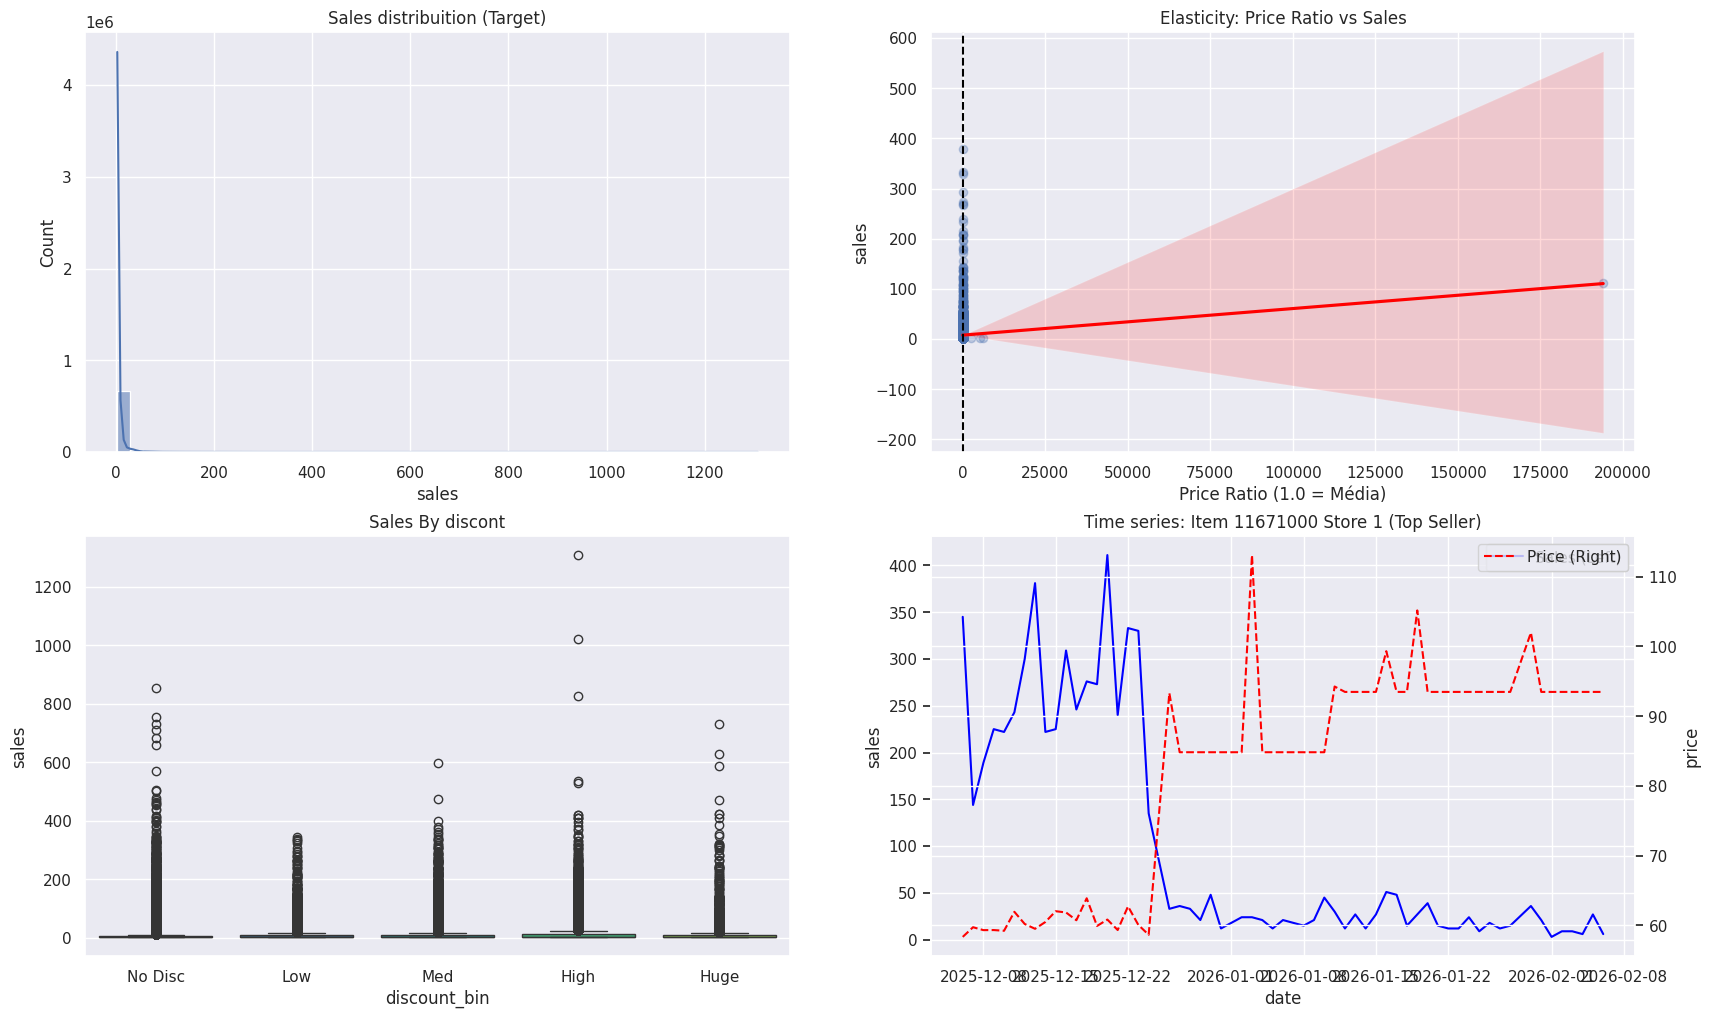


Checking the correlation:
sales           1.000000
sales_lag_7     0.546175
discount_pct    0.048360
price           0.041752
Name: sales, dtype: float64


In [19]:
# ==============================================================================
# 4.0. EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================================
df4 = df3.copy()

# Size adjustment
plt.figure(figsize=(20, 12))

# 4.1. Univariate Analysis (Target Variable)
plt.subplot(2, 2, 1)
sns.histplot(df4['sales'], bins=50, kde=True)
plt.title('Sales distribuition (Target)')

# 4.2. Bivariate: Price Ratio vs Sales
plt.subplot(2, 2, 2)
# Data sample 10k
sample_eda = df4.sample(min(10000, len(df4)))
sns.regplot(x='price_ratio', y='sales', data=sample_eda,
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.axvline(1.0, color='black', linestyle='--')
plt.title('Elasticity: Price Ratio vs Sales')
plt.xlabel('Price Ratio (1.0 = Média)')

# 4.3. Discount Impact (Boxplot)
plt.subplot(2, 2, 3)
df4['discount_bin'] = pd.cut(df4['discount_pct'],
                             bins=[-0.1, 0.05, 0.15, 0.30, 0.50, 1.0],
                             labels=['No Disc', 'Low', 'Med', 'High', 'Huge'])
sns.boxplot(x='discount_bin', y='sales', data=df4, palette="viridis", hue='discount_bin', legend=False)
plt.title('Sales By discont')

# 4.4. Time Series & Autocorrelation
plt.subplot(2, 2, 4)

# Getting the top item
top_item = df4.groupby(['store_id', 'item_id'])['sales'].sum().idxmax()
best_store, best_item = top_item

# Filtering the last 60 days
filter_best = (df4['store_id'] == best_store) & (df4['item_id'] == best_item)
aux = df4[filter_best].sort_values('date').tail(60)

# Ploting price and sales
sns.lineplot(x='date', y='sales', data=aux, label='Sales (Left)', color='blue')
ax2 = plt.twinx()
sns.lineplot(x='date', y='price', data=aux, label='Price (Right)', color='red', ax=ax2, linestyle='--')

plt.title(f'Time series: Item {best_item} Store {best_store} (Top Seller)')
plt.show()

# --- LAG IMPORTANCE ---
print("\nChecking the correlation:")
correlation = df4[['sales', 'sales_lag_7', 'price', 'discount_pct']].corr()['sales']
print(correlation.sort_values(ascending=False))

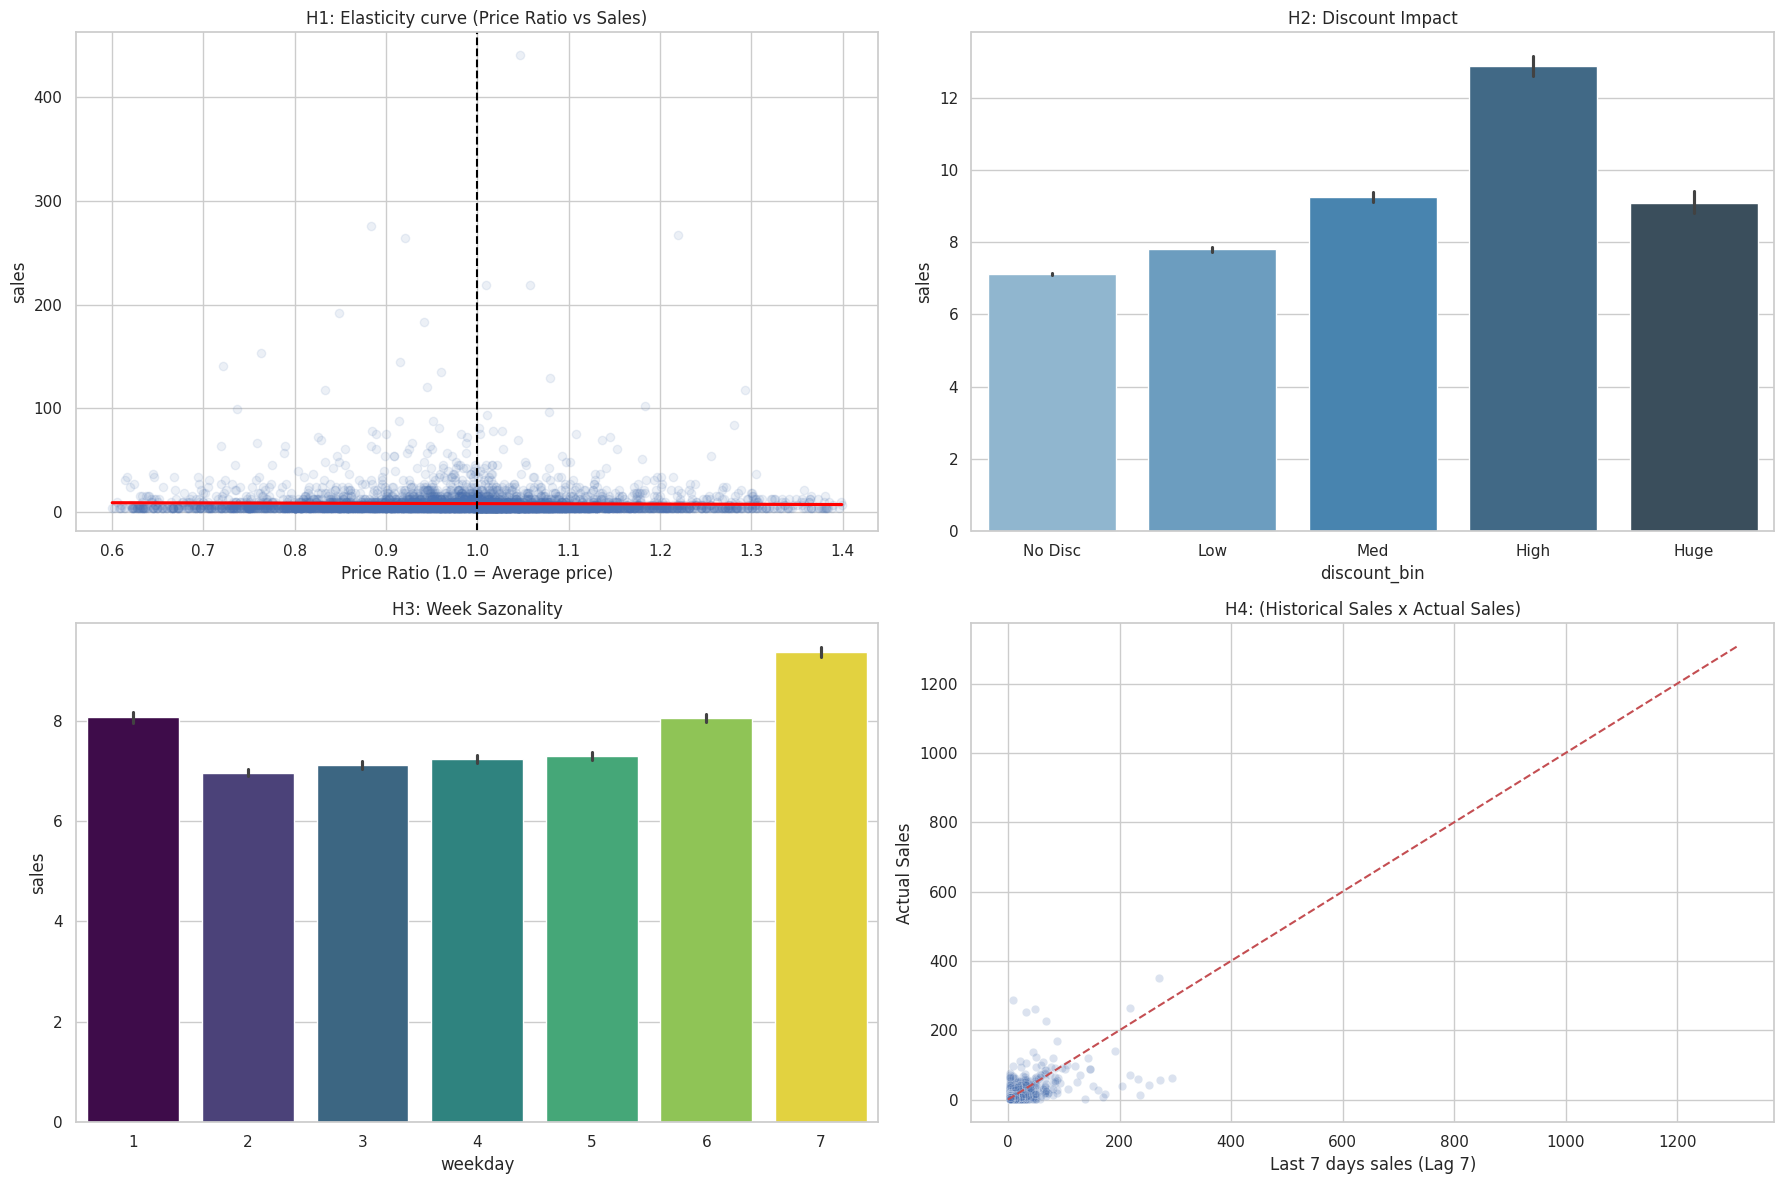

In [20]:
# ==============================================================================
# 4.0. EXPLORATORY DATA ANALYSIS (hypothesis)
# ==============================================================================
df4 = df3.copy()

# Config
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (18, 12)

# Create 4 subplots
fig, axs = plt.subplots(2, 2)

# --- hypothesis 1: Price Elasticity ---
# H1: Greater avarege price, less sales.
aux1 = df4[(df4['price_ratio'] > 0.6) & (df4['price_ratio'] < 1.4)]
sns.regplot(x='price_ratio', y='sales', data=aux1.sample(5000),
            scatter_kws={'alpha':0.1}, line_kws={'color':'red'}, ax=axs[0, 0])
axs[0, 0].axvline(1.0, color='black', linestyle='--')
axs[0, 0].set_title("H1: Elasticity curve (Price Ratio vs Sales)")
axs[0, 0].set_xlabel("Price Ratio (1.0 = Average price)")

# --- hypothesis 2: Disconte Limit ---
# H2: Small discounts (<5%) doesn't work.
# Recreating bins in case they don't exist
if 'discount_bin' not in df4.columns:
    bins = [-0.1, 0.05, 0.15, 0.30, 0.50, 1.0]
    labels = ['No Disc', 'Low', 'Med', 'High', 'Huge']
    df4['discount_bin'] = pd.cut(df4['discount_pct'], bins=bins, labels=labels)

sns.barplot(x='discount_bin', y='sales', hue='discount_bin', data=df4,
            palette="Blues_d", legend=False, ax=axs[0, 1])
axs[0, 1].set_title("H2: Discount Impact")

# --- hypothesis 3: Week Sazonality ---
# H3: Week day matter more than the price?
col_weekday = 'weekday' if 'weekday' in df4.columns else 'day_of_week'

sns.barplot(x=col_weekday, y='sales', hue=col_weekday, data=df4,
            palette="viridis", legend=False, ax=axs[1, 0])
axs[1, 0].set_title("H3: Week Sazonality")

# --- hypothesis 4: Autocorrelation ---
# H4: last week sale (Lag 7) it's a strong predictor of the actual sale.
sns.scatterplot(x='sales_lag_7', y='sales', data=df4.sample(5000),
                alpha=0.2, ax=axs[1, 1])
axs[1, 1].plot([0, df4['sales'].max()], [0, df4['sales'].max()], 'r--')
axs[1, 1].set_title("H4: (Historical Sales x Actual Sales)")
axs[1, 1].set_xlabel("Last 7 days sales (Lag 7)")
axs[1, 1].set_ylabel("Actual Sales")

plt.tight_layout()
plt.show()

In [21]:
# ==============================================================================
# 5.0. DATA PREPARATION
# ==============================================================================
df5 = df3.copy()

# --- 5.1. ENCODING CATEGORICAL VARIABLES ---
from sklearn.preprocessing import LabelEncoder

le_store = LabelEncoder()
le_item = LabelEncoder()

df5['store_id'] = le_store.fit_transform(df5['store_id'])
df5['item_id'] = le_item.fit_transform(df5['item_id'])

print(" IDs Encoded.")

# --- 5.2. CYCLICAL ENCODING (TIME VARIABLES) ---
# Month (12 cycle)
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# Weekday (7 cycle)
col_weekday = 'weekday' if 'weekday' in df5.columns else 'day_of_week'

df5['weekday_sin'] = df5[col_weekday].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['weekday_cos'] = df5[col_weekday].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# Week of Year (52 cycle)
df5['week_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

print("Time Variables Cyclically Encoded.")

# --- 5.3. SPLIT TRAIN vs TEST (TIME BASED) ---
max_date = df5['date'].max()
cutoff_date = max_date - pd.Timedelta(weeks=12)

print(f"--- Splitting Data ---")
print(f"Max Date in DB: {max_date}")
print(f"Cutoff Date:    {cutoff_date}")

train = df5[df5['date'] < cutoff_date]
test = df5[df5['date'] >= cutoff_date]

print(f"Train Size: {len(train)} rows")
print(f"Test Size:  {len(test)} rows")

# --- 5.4. DEFINE FEATURES (X) and TARGET (y) ---
cols_selected = [
    'store_id', 'item_id',
    'price', 'list_price', 'discount_pct', 'price_ratio',
    'sales_lag_7', 'sales_ma_28d',
    'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos'
]

X_train = train[cols_selected]
y_train = train['sales']

X_test = test[cols_selected]
y_test = test['sales']

print(f"\nFinal Features: {cols_selected}")

 IDs Encoded.
Time Variables Cyclically Encoded.
--- Splitting Data ---
Max Date in DB: 2026-02-06 00:00:00
Cutoff Date:    2025-11-14 00:00:00
Train Size: 639759 rows
Test Size:  52953 rows

Final Features: ['store_id', 'item_id', 'price', 'list_price', 'discount_pct', 'price_ratio', 'sales_lag_7', 'sales_ma_28d', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos']


 Applying log
Training Random Forest (Target: Log Sales)...
🔮 Gerando previsões e revertendo para escala real...

 LOG-MODEL PERFORMANCE SHOWDOWN
1. RMSE:
   - Baseline: 25.96
   - Log-Model: 18.59
   - Improvment: 28.41%

2. R² Score:
   - Model R²: 44.61% (How much of variancy we explain?)


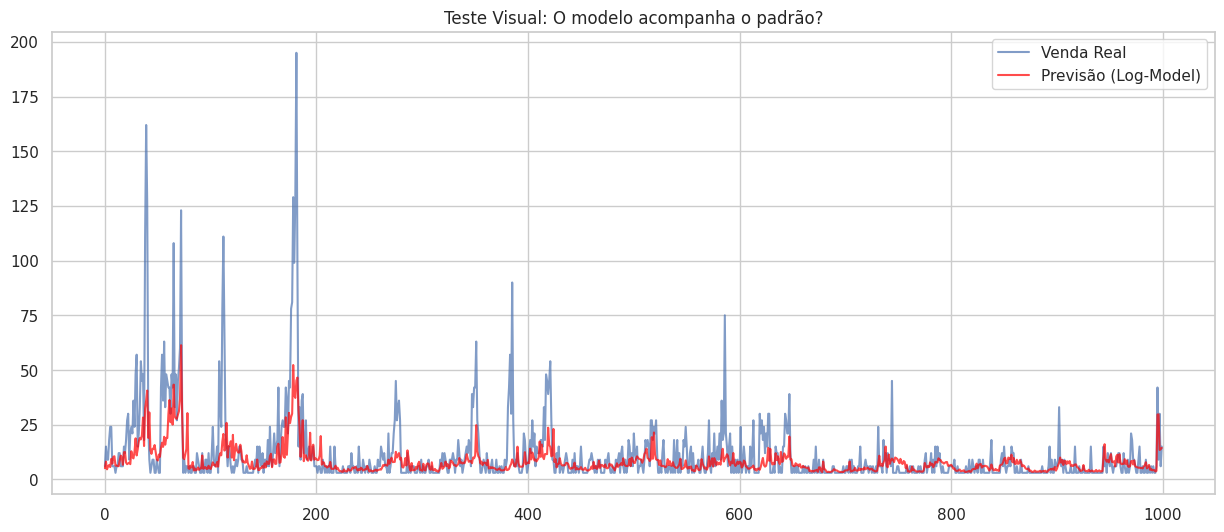

In [22]:
# ==============================================================================
# 6.0. MACHINE LEARNING (LOG-TRANSFORMED)
# Strategy: Training Sales log to reduct error variancy.
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1. Data Preparation (LOG SCALE) ---
# Applying logs(x+1)
# Help to normalize the distribuition (Gauss)
print(" Applying log")
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- 2. Training Log Model ---
print("Training Random Forest (Target: Log Sales)...")

# Tunning parameters

rf_log_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    random_state=42,
    n_jobs=-1
)

rf_log_model.fit(X_train, y_train_log)

# --- 3. Prediction and Revertion  ---
# The model predicts in log. We need to revert (expm1)
print("🔮 Gerando previsões e revertendo para escala real...")
yhat_log = rf_log_model.predict(X_test)
yhat_real = np.expm1(yhat_log) # Inversion of log1p

# --- 4. Performance ---
# Baseline (Avarege Model)
avg_sales = train['sales'].mean()
base_preds = np.full(len(y_test), avg_sales)
base_rmse = np.sqrt(mean_squared_error(y_test, base_preds))

# Model Metrics
rf_mae = mean_absolute_error(y_test, yhat_real)
rf_rmse = np.sqrt(mean_squared_error(y_test, yhat_real))
rf_r2 = r2_score(y_test, yhat_real)

print("\n" + "="*40)
print(" LOG-MODEL PERFORMANCE SHOWDOWN")
print("="*40)
print(f"1. RMSE:")
print(f"   - Baseline: {base_rmse:.2f}")
print(f"   - Log-Model: {rf_rmse:.2f}")
print(f"   - Improvment: {((base_rmse - rf_rmse)/base_rmse)*100:.2f}%")

print(f"\n2. R² Score:")
print(f"   - Model R²: {rf_r2:.2%} (How much of variancy we explain?)")

# --- 5. Actual vs Predicted ---
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:1000], label='Venda Real', alpha=0.7)
plt.plot(yhat_real[:1000], label='Previsão (Log-Model)', color='red', alpha=0.7)
plt.title("Teste Visual: O modelo acompanha o padrão?")
plt.legend()
plt.show()

rf_model = rf_log_model

In [23]:
# ==============================================================================
# 6.1. HYPERPARAMETER TUNING (SAFE MODE)
# Goal: Find the best parameters without crashing Colab RAM.
# ==============================================================================
#from sklearn.model_selection import RandomizedSearchCV



# 1. Define Grid of parameters
#param_grid = {
#    'n_estimators': [100, 200],
#    'max_depth': [15, 20, 25],
#    'min_samples_split': [5, 10],
#    'min_samples_leaf': [2, 4],
#    'max_features': ['sqrt', 'log2']
#}

# 2. Search Config
#rf_random = RandomizedSearchCV(
#    estimator=RandomForestRegressor(random_state=42), #
#    param_distributions=param_grid,
#    n_iter=10,
#    cv=3,
#    verbose=2,
#    random_state=42,
#    n_jobs=1,
#    scoring='neg_root_mean_squared_error'
#)

# 3. Training
#print(" Training models... (This can take long)")
#rf_random.fit(X_train, y_train)

# 4. Best model
#best_model = rf_random.best_estimator_

#print("\n" + "="*40)
#print(f" Best parameters find:")
#print(f"{rf_random.best_params_}")
#print("="*40)

# 5. Evaluate the improvment
#y_pred_tuned = best_model.predict(X_test)
#rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
#r2_tuned = r2_score(y_test, y_pred_tuned)

#print(f"New RMSE: {rmse_tuned:.2f} (Antes: {rf_rmse:.2f})")
#print(f"New R²:   {r2_tuned:.2%} (Antes: {rf_r2:.2%})")

#rf_model = best_model

In [24]:
# ==============================================================================
# 7.0. FINAL MERGE: FULL HISTORY DIAGNOSTIC (WITH FEATURE RE-CREATION)
# Goal: Consolidate actual history vs Model Predictions (Converted back to Real Units).
# ==============================================================================
import pandas as pd
import numpy as np

# 1. Load the complete data
df_full = df3.copy()

# --- Recreate time features ---

# Date check
df_full['date'] = pd.to_datetime(df_full['date'])

# Extracting time aggregations
df_full['month'] = df_full['date'].dt.month
df_full['weekday'] = df_full['date'].dt.dayofweek
df_full['week'] = df_full['date'].dt.isocalendar().week.astype(int)

# Recreate cicle features
df_full['month_sin'] = np.sin(2 * np.pi * df_full['month']/12)
df_full['month_cos'] = np.cos(2 * np.pi * df_full['month']/12)

df_full['weekday_sin'] = np.sin(2 * np.pi * df_full['weekday']/7)
df_full['weekday_cos'] = np.cos(2 * np.pi * df_full['weekday']/7)

df_full['week_sin'] = np.sin(2 * np.pi * df_full['week']/52)
df_full['week_cos'] = np.cos(2 * np.pi * df_full['week']/52)


# 2. Define Features as trained
features = X_train.columns.tolist()

print(f"🔮 Generating predictions to {len(df_full)} rows...")

try:
    # First: The model predicts in log escale
    raw_log_preds = rf_model.predict(df_full[features])

    # Second: Reverting log
    df_full['predicted_sales'] = np.expm1(raw_log_preds)

except Exception as e:
    print(f"❌ Erro na predição: {e}")
    print("Tentativa de diagnóstico: Verifique se todas as colunas abaixo existem no df_full:")
    print(features)
    # Just in case
    df_full['predicted_sales'] = 0

# Round
df_full['predicted_sales'] = df_full['predicted_sales'].round(1)

# 3. Diagnostic error
df_full['error_abs'] = (df_full['sales'] - df_full['predicted_sales']).abs()

# 4. Selecting Final Columns
cols_export = [
    'date', 'store_id', 'item_id',
    'sales',             # Real (Historic)
    'predicted_sales',   # AI (Prediction)
    'price',
    'list_price',
    'discount_pct',
    'error_abs'
]

df_export = df_full[cols_export].copy()


print("\n Full table ready!")
display(df_export.tail(20))

🔮 Generating predictions to 692712 rows...

 Full table ready!


,date,store_id,item_id,sales,predicted_sales,price,list_price,discount_pct,error_abs
865383,2024-03-28,9,9903800,3,3.3,84.983,84.983,0.000000,0.3
865395,2024-09-27,9,9908000,3,3.6,379.066,382.330,0.008537,0.6
865396,2024-10-03,9,9908000,3,3.3,365.500,382.330,0.044020,0.3
865397,2024-10-24,9,9908000,3,3.5,365.330,382.330,0.044464,0.5
865398,2024-10-30,9,9908000,3,3.4,320.178,382.330,0.162561,0.4
865434,2025-01-25,9,9915400,3,3.5,377.655,390.830,0.033710,0.5
865447,2024-06-28,9,9916800,3,3.6,91.018,107.083,0.150024,0.6
865450,2024-10-17,9,9916800,3,3.5,104.720,107.083,0.022067,0.5
865452,2024-11-29,9,9916800,3,3.2,107.083,107.083,0.000000,0.2
865453,2024-12-16,9,9916800,3,3.4,107.083,107.083,0.000000,0.4


In [25]:
# ==============================================================================
# 8.0. EXPORT TO BIGQUERY
# Goal: Send the "Actual vs Forecast" table to BigQuery.
# ==============================================================================
import pandas_gbq

# Config
project_id = 'otimizador-cargas'
dataset_id = 'sales'
table_name = 'forecast_vs_actuals'

destination_table = f"{dataset_id}.{table_name}"

print(f"Sending {len(df_export)} rows to BigQuery...")
print(f"Dataset: {destination_table}")

try:
    df_export.to_gbq(
        destination_table=destination_table,
        project_id=project_id,
        if_exists='replace',
        chunksize=10000,
        progress_bar=True
    )
    print("\n✅ Sucess!.")

except Exception as e:
    print(f"\n❌ Erro: {e}")

Sending 692712 rows to BigQuery...
Dataset: sales.forecast_vs_actuals


/tmp/ipython-input-2016204554.py:18: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df_export.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 8774.69it/s]


✅ Sucess!.
